# The Light Curve Analysis of TRAPPIST-1d&e transits
## Mayuko Mori / The University of Tokyo

このノートでは、JpGU2018にて発表したTRAPPIST-1の惑星質量推定のためのライトカーブ解析についての方法をまとめました。  
この研究は2017年度卒業研究として行ったものです。  
疑問点やアドバイス等あればぜひこちらまでお願いします  
→mori@astron.s.u-tokyo.ac.jp

## 0. 解析に必要なモジュールの準備

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

## 1. データフレームの準備

### 1-1 測光結果を読み込む

測光には福井暁彦さんのプログラムafapphotを用いた。  
様々なアパーチャー半径で測光した結果、目で見てライトカーブが綺麗に見えるアパーチャー半径を複数用意した。  
以下で行うフィッティングを様々な半径で行なった結果BIC等の基準から最も良くフィッティングできる半径を残すことにする（結果としては13pixだった）。

In [3]:
df = pd.read_csv('TRAPPIST-1_171105_zband.csv', delimiter=',', parse_dates=True)
df = df.drop(['Unnamed: 0'],axis=1)
df.head(3)

,GJD-2450000,airmass,sky,dx,dy,flux(10),err(10),flux(11),err(11),flux(12),err(12),flux(13),err(13),flux(14),err(14),flux(15),err(15)
0,8062.876429,1.5601,1109.2,-0.027,-2.954,0.998611,0.004243,0.999285,0.004415,0.997248,0.004615,0.997372,0.004839,0.997539,0.005075,0.995310,0.005315
1,8062.877054,1.5560,979.4,-0.084,-2.454,1.003984,0.004132,1.004214,0.004304,1.004072,0.004506,1.003590,0.004729,1.005631,0.004968,1.005165,0.005211
2,8062.877679,1.5516,875.1,-0.130,-1.302,1.006406,0.004044,1.004540,0.004190,1.004198,0.004377,1.003489,0.004581,1.003510,0.004800,1.003624,0.005028


GJDをBJDに変換したものに置き換える。(変換プログラム：http://astroutils.astronomy.ohio-state.edu/time/utc2bjd.html)

In [4]:
df = df.rename(columns={'GJD-2450000': 'time'})
df_BJD = pd.read_csv('BJD.txt', delimiter=' ', header=-1,parse_dates=True)
df_BJD.columns=['BJD']
df['time']=df_BJD['BJD']-2450000
df.head(3)

,time,airmass,sky,dx,dy,flux(10),err(10),flux(11),err(11),flux(12),err(12),flux(13),err(13),flux(14),err(14),flux(15),err(15)
0,8062.880338,1.5601,1109.2,-0.027,-2.954,0.998611,0.004243,0.999285,0.004415,0.997248,0.004615,0.997372,0.004839,0.997539,0.005075,0.995310,0.005315
1,8062.880963,1.5560,979.4,-0.084,-2.454,1.003984,0.004132,1.004214,0.004304,1.004072,0.004506,1.003590,0.004729,1.005631,0.004968,1.005165,0.005211
2,8062.881588,1.5516,875.1,-0.130,-1.302,1.006406,0.004044,1.004540,0.004190,1.004198,0.004377,1.003489,0.004581,1.003510,0.004800,1.003624,0.005028


In [5]:
len(df)

306

データの数は306点。これをプロットしてみると以下のようになる。

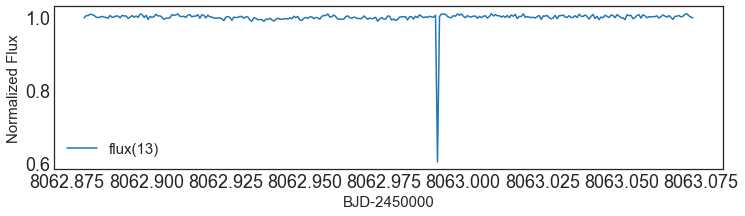

In [6]:
fig,ax = pl.subplots(1,1,figsize=(12,3),sharex=True)

time = df['time']
flux = df['flux(13)']

ax.plot(time, flux)

#add plot labels
ax.set_xlabel('BJD-2450000')
ax.set_ylabel('Normalized Flux')
ax.legend(loc='lower left')

### 1-2 外れ値を除く

上のグラフから、1箇所明らかに外れている値があるのがわかる。確認したところすべておなじフレーム(MSCT2_1711050228)のデータだったので、fluxの平均から$5\sigma$以上離れている点を除くと、その1点だけが除かれた。（おそらくcosmic rayの影響）

In [7]:
sigma = 5
df=df[np.abs(df['flux(12)']-df['flux(12)'].mean())<=(sigma*df['flux(12)'].std())]

また、airmassについても1点だけおかしい点があった。こちらはFits header書き込みエラーだと思われるので、データ点を減らさないために、前後の平均値を用いることにして使うデータに戻してやった。

Int64Index([9], dtype='int64')


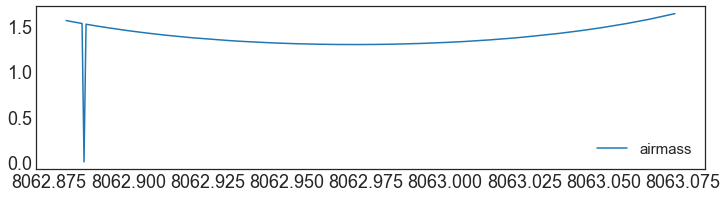

In [8]:
fig,ax = pl.subplots(1,1,figsize=(12,3))
ax.plot(df['time'],df['airmass'],label='airmass')
ax.legend(loc='lower right')

print(df[np.abs(df['airmass']-df['airmass'].mean())>(sigma*df['airmass'].std())].index)

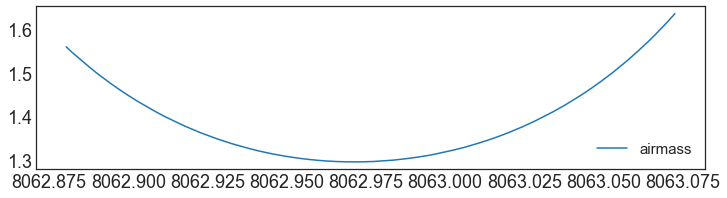

In [9]:
df['airmass'][9]=(df['airmass'][8]+df['airmass'][10])/2.

fig,ax = pl.subplots(1,1,figsize=(12,3))
ax.plot(df['time'],df['airmass'],label='airmass')
ax.legend(loc='lower right')

In [10]:
len(df)

305

外れ値を除いたデータ点は305点、プロットすると以下のようになる。

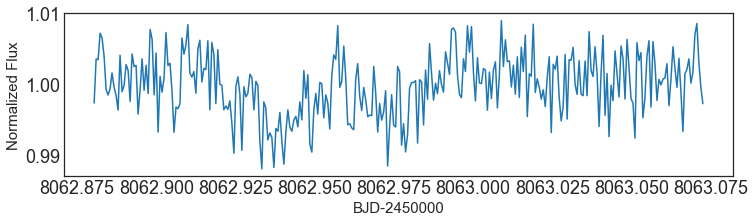

In [11]:
fig,ax = pl.subplots(1,1,figsize=(12,3),sharex=True)

time = df['time']
flux = df['flux(13)']
err = df['err(13)']

ax.plot(time, flux)

#add plot labels
ax.set_xlabel('BJD-2450000')
ax.set_ylabel('Normalized Flux')

左側の凹みがe、右側がdのトランジットと予想されるが、確認はモデルフィットの際に行う。

## 2. モデルの準備
### 2-1 トランジットのモデルを定義する
様々な物理量からトランジットのライトカーブモデルを描くプログラムPyTransit(https://github.com/hpparvi/PyTransit )を、2つのトランジットが重なった状況にも適応できるようにした。　　　

今回のノートでは簡単のため(また精度がそこまで高くなく、大きく変化する可能性のあるトランジット中心の値以外は先行研究の値を用いた方がよいため）、 フィッティングの際に半径比kとトランジット中心tcのみを変動させ、その他のパラメタは固定している。状況に応じて固定したパラメタをフリーにしたり、priorの置き方も工夫する。

In [12]:
from pytransit import MandelAgol

def transit_model_q(parameters, fix, time, model=MandelAgol()):
 
    k_d,tc_d,k_e,tc_e = parameters
    p_d,a_d,b_d,p_e,a_e,b_e,q1_,q2_ = fix
    
    #compute inclination
    inc_d   = np.arccos(b_d/a_d)
    inc_e   = np.arccos(b_e/a_e)
    #convert q to u
    u1,u2 = q_to_u(q1_, q2_)
    #evaluate the model
    m = 1-(1-model.evaluate(time, k_d, (u1,u2), tc_d, p_d, a_d, inc_d))-(1-model.evaluate(time, k_e, (u1,u2), tc_e, p_e,a_e, inc_e))
    
    return m

### 2-2 必要な物理量の代入
トランジットモデルを描くための物理量を先行文献から求める。

In [13]:
from astropy import units as u

#values come from S.Wang et al.(2017) 
tc_0d  = 7682.2921#pm 0.0023(BJD-2450000)
_Pd   = 4.04982 #pm 0.00017(days)
tc_d  = tc_0d+94*_Pd
_ad   = 0.02145 #semimajor axis (AU)
_Rpd  = 0.772 #pm 0.030 (R_earth)

#from M.Gillon et al.(2017)
_bd   = 0.17 #pm0.11

_Rs = 0.117 #pm 0.0036(Rsun)
k_d = _Rpd/_Rs/u.Rsun.to(u.Rearth)
a_s_d= _ad/_Rs/u.Rsun.to(u.au)

#values come from S.Wang et al.(2017) 
tc_0e= 7574.9829 #pm 0.0025(BJD-2450000)
_Pe   = 6.099570 #pm 0.000091 (days) w/o TTV
tc_e  = tc_0e+80*_Pe
_ae   = 0.02818 #semimajor axis (AU)
_Rpe  = 0.918 #pm0.039 (R_earth)

#from M.Gillon et al.(2017)
_be   = 0.12 #+0.11/-0.09

k_e = _Rpe/_Rs/u.Rsun.to(u.Rearth)
a_s_e= _ae/_Rs/u.Rsun.to(u.au)

主星TRAPPIST-1の有効温度、表面重力、金属量から、プログラムlimbdark(https://github.com/john-livingston/limbdark )を用いて周縁減光パラメタの理論値を求める。  

In [14]:
import limbdark as ld

#from M.Gillon(2017)
teff, uteff = 2559,  50 
logg, ulogg = 4.39, 0.03 
feh, ufeh   = 0.04,  0.08 

ldc = ld.claret("z*", teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
#ldc = u1_,u1err, u2_,u2err

周縁減光のパラメタとして、$(u_1,u_2)$よりも以下で定義される$(q_1,q_2)$の方が使いやすい(範囲を指定すれば物理的にありえない状況を除ける)ため、変換の式。

In [15]:
def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

In [16]:
q1_,q2_ = u_to_q(ldc[0],ldc[2])

ためしに生データに理論値を入れたトランジットモデルを重ねると以下のようになる。

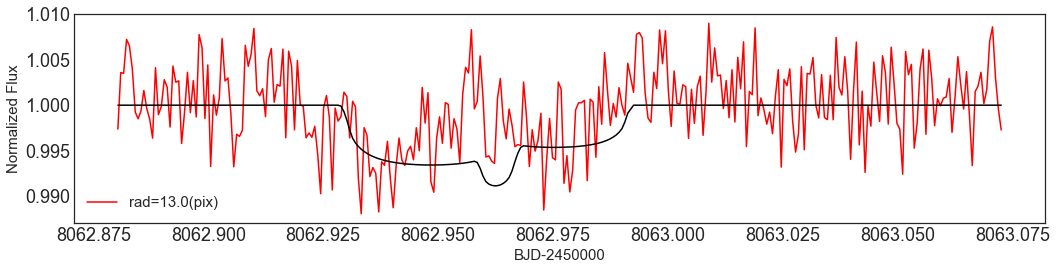

In [17]:
fig,ax = pl.subplots(1,1,figsize=(15,4),sharex=True)

time = df['time']
flux = df['flux(13)']

ax.plot(time, flux, 'r-', label='rad=13.0(pix)')

transit_params_d     = [k_d,tc_d]
transit_params_e     = [k_e,tc_e]

transit_params=transit_params_d+transit_params_e

transit_fix = [_Pd,a_s_d,_bd,_Pe,a_s_e,_be,q1_,q2_]

transit_model = transit_model_q(transit_params,transit_fix, time, model=MandelAgol())

ax.plot(time, transit_model , color ='black')

ax.set_xlabel('BJD-2450000')
ax.set_ylabel('Normalized Flux')
ax.legend(loc='lower left')
pl.tight_layout()

本来はTRAPPIST-1dとeのトランジットが重なる予定だった（それを狙った観測であった）。しかし実際にはTTVの影響でタイミングが重ならなかったことがわかる。

### 2-3 systematicsのモデルを定義する

systematics = flux / transit_modelとして、各点のsystematics($s_i$)について

$s_i = w_1 X_{i1} + w_2 X_{i2} + \cdots $

という線形の組み合わせが成り立っているとする。($X_{im}$はairmassやdxのような要素、w_mはパラメタとなる重み。)  
これをベクトル表記すると

$\vec{s }= X \cdot \vec{w }$

と表される。pythonの行列計算を用いる。逆行列を求めるため正方行列にする必要があるので以下のようにしている。

$
X^T \cdot s = X^T \cdot X \cdot w \\
(X^T \cdot X)^{-1} \cdot X^T \cdot s = w
$

### 2-3-1. systematicsの組み合わせを用意する

systematicsが上記のような線形の組み合わせで表されると近似した場合、すべての要素を入れれば入れるほど正しい結果になるとは限らず、どの要素を入れるかを考慮する必要がある。  
プログラムを用いてその組み合わせを用意する。

In [18]:
import itertools
free=[['dx'],['dy'],['airmass'],['sky'],['del_time']]

seq1=['dx','dy','airmass','sky','del_time']
temp1=list(itertools.combinations(seq1,1))
temp2=list(itertools.combinations(seq1,2))
temp3=list(itertools.combinations(seq1,3))

m=0
for m in range(len(temp3)):
    b=[seq1[n] for n in range(len(seq1)) if not seq1[n] in temp3[m]]
    free.append(b)
    m += 1
m=0
for m in range(len(temp2)):
    b=[seq1[n] for n in range(len(seq1)) if not seq1[n] in temp2[m]]
    free.append(b)
    m += 1    
m=0
for m in range(len(temp1)):
    b=[seq1[n] for n in range(len(seq1)) if not seq1[n] in temp1[m]]
    free.append(b)
    m += 1

free.append(seq1)

上で用意したのは名前の組み合わせなので、ここから実際の値の組み合わせを準備する

In [19]:
time_mean = (df['time'][0]+df['time'][304])/2
df['del_time']=df['time']-time_mean

In [20]:
sys_combination = [] 

for n in range(len(free)):
    X=np.ones_like(time)
    for m in range(len(free[n])):
        X=np.c_[X,df[free[n][m]]]
    sys_combination.append(X)

このうちどの組み合わせを$X$として採用するかをフィッティングして（BIC等を基準にして）決めたい。$w$がフリーパラメタとなるが、初期値が適切でないとおかしな結果を出してしまうので、初期値として、OOT(Out-Of-Transit)からざっと求めた値を用いることにする。　　
### 2-3-2 各systematicsの組み合わせについて$\vec{w}$の値を求める
まず、OOTのデータ点(ざっと)を用意する。

In [21]:
df2 = df[~((df['time']>8062.910) & (df['time']< 8063.00))]
time_OOT = df2['time']
flux_OOT = df2['flux(13)']

これについて$\vec{w}$を求める

In [22]:
w_before = []
sys_combination_OOT = [] 
for n in range(len(free)):
    X=np.ones_like(time_OOT)
    for m in range(len(free[n])):
        X=np.c_[X,df2[free[n][m]]]
    sys_combination_OOT.append(X)
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, flux_OOT))
    w_before.append(w)

これで各systematicsの組み合わせについて$\vec{w}$のおよその値が求められた。例えば

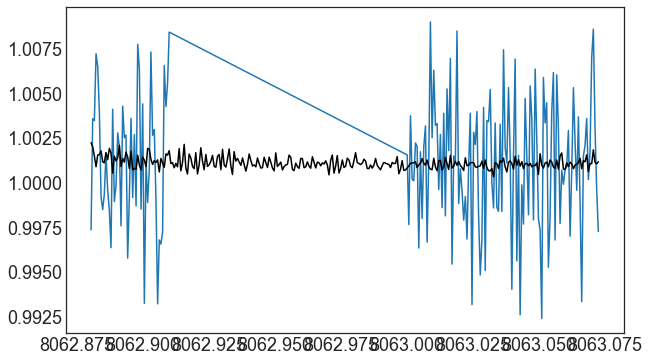

In [23]:
w=w_before[10]
X=sys_combination[10]
sys_model = np.dot(X,w)


fig,ax = pl.subplots(1,1,figsize=(10,6),sharex=True)
pl.plot(time_OOT,flux_OOT)
pl.plot(time,sys_model,'k-')

## 4. 各パラメタセットでフィットし最も良いセットを決める(MLE)

systematicsについて様々なパラメタの組み合わせを用意した。パラメタは、増やせば増やすほどよくフィットされてしまうが、これは物理的に正しくない「overfitting」を起こしている可能性がある。  
そこで、カイ自乗でなくBICという値を用意し、これを小さくするようにフィッティングを行う。

### 4-1 基準: Bayesian Information Criteria (BIC)

In [35]:
def rms(flux,flux_model):
    residual = flux-flux_model
    return np.sqrt(np.mean((residual)**2))

def chisq(flux,flux_model,err):
    residual = flux-flux_model
    return np.sum((residual/err)**2)

#BIC = chi2 + num_p * np.log(num_d)

### 4-2 フィッティング
最小にする関数を定義。

In [36]:
import scipy.optimize as op

def obj (params_full,fix, t, f, err):
    '''
    objective function: chi-squared
    '''
    transit_params=params_full[:4]
    sys_params=params_full[4:]
    
    m = transit_model_q(transit_params, fix,t, model=MandelAgol())
    s = np.dot(sys_use,sys_params)
    
    Tc_d = params_full[1]
    Tc_e = params_full[3]
    if not (time[0]<Tc_d<time[304]):
        return np.inf
    if not (time[0]<Tc_e<time[304]):
        return np.inf
    
    kd = params_full[0]
    ke = params_full[2]
    if not (0 < kd < 1):
        return np.inf
    if not (0 < ke < 1):
        return np.inf
    
    return np.sum(((f-s*m)/err)**2)

使う(最適化する)パラメタを整える。たとえばsystematicsの組み合わせの13番目、['dx', 'airmass']を使うならば、

In [37]:
time = df['time']

flux = df['flux(13)']
err  = df['err(13)']
    
dx   = df['dx']
dy   = df['dy']
airmass = df['airmass']
sky     = df['sky']

transit_params_d     = [k_d,tc_d]
transit_params_e     = [k_e,tc_e]

transit_params=transit_params_d+transit_params_e
sys_use = sys_combination[13]
w = w_before[13]

#combine optimized transit params and sys params
full_params = np.concatenate((transit_params, w), axis=0)
full_params

array([  6.04923922e-02,   8.06297518e+03,   7.19326633e-02,
         8.06294850e+03,   9.99960742e-01,   1.11969222e-04,
         9.71992474e-04])

順に、惑星dの$k$,$T_c$、  惑星eの$k$,$T_c$、
使用するsystematicsのウェイト$\vec{w}$
である。  

まず簡単にフィッティングしてみるため、numpy.optimize.minimizeをつかう。

In [38]:
result = op.minimize(obj, full_params, args=(transit_fix,time,flux,err), method='nelder-mead')

#compute flux after optimization
params_after     = np.copy(result.x)
transit_params_after = params_after[:4]
sys_params_after = params_after[4:]

transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
sys_model = np.dot(sys_use,sys_params_after)
print('\nsystematics is' ,free[13])
#compute rms
rms_after = rms(flux,sys_model*transit_model)
print('rms w/o systematics:\n{:.8f}'.format(rms_after))
        
#compute BIC
num_d=len(time)
num_p=full_params.size
chi2 = chisq(flux,sys_model*transit_model,err)
        
dof = num_d - num_p
red_chi2 = chi2 / dof
BIC = chi2 + num_p * np.log(num_d)
        
print('chisq:\n{:.8f}'.format(chi2))
print('reduced_chisq:\n{:.8f}'.format(red_chi2))
print('BIC: {:.4f}'.format(BIC))


systematics is ['dx', 'airmass']
rms w/o systematics:
0.00364071
chisq:
258.07404710
reduced_chisq:
0.86602029
BIC: 298.1162


optimize後のモデルは以下のようになった。

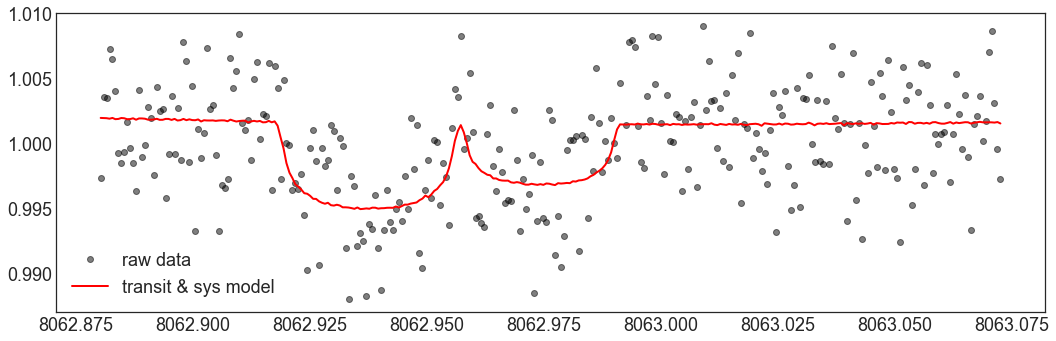

In [30]:
fig = pl.figure(figsize=(15,5))
#plot corrected data
pl.plot(time, flux, 'ko', alpha=0.5, label='raw data')
#pl.set_title('raw data & transit+systematics models (z-band)', fontsize=18)
#plot transit+sys models
pl.plot(time, transit_model*sys_model, 'r-', lw=2, label='transit & sys model');

pl.legend(fontsize=18)
fig.tight_layout()

さらにここで、(短いチェーンの）MCMCを用いて、optimizeしたものからさらに少し動いた位置での値を試してより最適な方を選択する、という手法を導入する。emcee(https://emcee.readthedocs.io/en/stable/#) というパッケージを用いた。

In [32]:
import emcee
from tqdm import tqdm

def runmc(obje, params, args=(transit_fix,time,flux,err),nsteps=500):
    dim = len(params)
    nwalkers = 100
    sampler = emcee.EnsembleSampler(nwalkers, dim, obje, args=args)

    pos0 = [params + 1e-4 * np.random.randn(dim) for i in range(nwalkers)]
    for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps)):
        pass
    idx = np.argmax(sampler.flatlnprobability)
    paramsmc = sampler.flatchain[idx]
    
    return paramsmc, sampler.flatlnprobability[idx]

In [33]:
resultmc, lnprobmc = runmc(lambda *x: -obj(*x), result.x,args=(transit_fix,time,flux,err),nsteps=500)

transit_params_after_mc = resultmc[:4]
sys_params_after = resultmc[4:]

transit_model2 = transit_model_q(transit_params_after_mc,transit_fix, time, model=MandelAgol())
sys_model = np.dot(sys_use,sys_params_after)
print('\nsystematics is' ,free[2])
#compute rms
rms_after2 = rms(flux,sys_model*transit_model2)
print('rms w/o systematics:\n{:.8f}'.format(rms_after2))
        
#compute BIC
num_d=len(time)
num_p=full_params.size
chi2 = chisq(flux,sys_model*transit_model2,err)
        
dof = num_d - num_p
red_chi2 = chi2 / dof
BIC = chi2 + num_p * np.log(num_d)
        
print('chisq:\n{:.8f}'.format(chi2))
print('reduced_chisq:\n{:.8f}'.format(red_chi2))
print('BIC: {:.4f}'.format(BIC))

500it [00:57,  9.48it/s]


systematics is ['airmass']
rms w/o systematics:
0.00361899
chisq:
254.76667194
reduced_chisq:
0.85492172
BIC: 294.8089


MCMCを使った場合の方がBICが3小さくなった。この場合をプロットしてみると

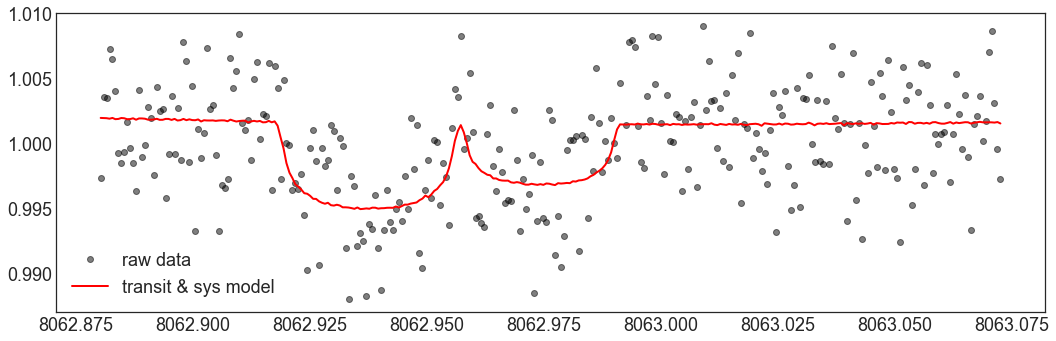

In [39]:
fig = pl.figure(figsize=(15,5))
pl.plot(time, flux, 'ko', alpha=0.5, label='raw data')
pl.plot(time, transit_model*sys_model, 'r-', lw=2, label='transit & sys model');

pl.legend(fontsize=18)
fig.tight_layout()

文献値、optimizeの結果、mcmcによるフィッティングの結果を並べると以下の通り。

In [40]:
np.c_[full_params,result.x,resultmc]

array([[  6.04923922e-02,   6.04924398e-02,   6.36341026e-02],
       [  8.06297518e+03,   8.06297414e+03,   8.06297437e+03],
       [  7.19326633e-02,   7.19326248e-02,   7.29153086e-02],
       [  8.06294850e+03,   8.06293746e+03,   8.06293755e+03],
       [  9.99960742e-01,   1.00036903e+00,   1.00768005e+00],
       [  1.11969222e-04,   1.11969799e-04,   2.02121608e-04],
       [  9.71992474e-04,   1.01983271e-03,  -4.03808313e-03]])

同様のことを様々なアパーチャー、31パターンのパラメタの組み合わせで行い、BICを計算する。（radiusの値を変化させる）  
なお、errはreduced$\chi^2$がおよそ1になるように0.935倍した(測光プログラムでおよそ良いエラーを出しているが過大・過少見積もりしている場合があるのでここで補正する)。

In [41]:
time = df['time']

radius = '13'　#ここを変えて回す
flux = df['flux('+radius+')']
err = df['err('+radius+')']*0.935

transit_params_d     = [k_d,tc_d]
transit_params_e     = [k_e,tc_e]

transit_params=transit_params_d+transit_params_e

BIC_list = []
rms_list=[]
reduced_chisq_list = []

params_after_mc1_list=[]
transit_params_after_list=[]
w_after_list=[]

count = 0


print('\naperture radius =' + radius+'pix')


for n in range(len(w_before)):
    sys_use = sys_combination[n]
    w = w_before[n]
    full_params = np.concatenate((transit_params, w), axis=0)

    result = op.minimize(obj, full_params, args=(transit_fix,time,flux,err), method='nelder-mead')
    resultmc, lnprobmc = runmc(lambda *x: -obj(*x), result.x,args=(transit_fix,time,flux,err),nsteps=100)

    if lnprobmc > -result.fun:
        best= resultmc
        print ("mcmc found better solution!!!!!!!")
    else:
        best = result.x

    params_after     = best

    params_after_mc1_list.append(params_after)
    transit_params_after = params_after[:4]
    transit_params_after_list.append(transit_params_after)
    sys_params_after = params_after[4:]
    w_after_list.append(sys_params_after)

    transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
    sys_model = np.dot(sys_use,sys_params_after)
    print('\nnumber',count)
    print('systematics is' ,free[n])
    #compute rms
    rms_after = rms(flux,sys_model*transit_model)
    print('rms w/o systematics:\n{:.8f}'.format(rms_after))

    #compute BIC
    num_d=len(time)
    num_p=full_params.size
    chi2 = chisq(flux,sys_model*transit_model,err)

    dof = num_d - num_p
    red_chi2 = chi2 / dof
    BIC = chi2 + num_p * np.log(num_d)

    #print('chisq:\n{:.8f}'.format(chi2))
    print('reduced_chisq:\n{:.8f}'.format(red_chi2))
    print('BIC: {:.4f}'.format(BIC))

    BIC_list.append(BIC)
    rms_list.append(rms_after)
    reduced_chisq_list.append(red_chi2)

    count += 1



aperture radius =13pix


100it [00:11,  7.98it/s]


mcmc found better solution!!!!!!!

number 0
systematics is ['dx']
rms w/o systematics:
0.00363099
reduced_chisq:
0.98171147
BIC: 327.8536


100it [00:10,  9.05it/s]


mcmc found better solution!!!!!!!

number 1
systematics is ['dy']
rms w/o systematics:
0.00362671
reduced_chisq:
0.97890126
BIC: 327.0133


100it [00:11,  8.32it/s]


mcmc found better solution!!!!!!!

number 2
systematics is ['airmass']
rms w/o systematics:
0.00362426
reduced_chisq:
0.97753513
BIC: 326.6049


100it [00:10,  9.87it/s]


mcmc found better solution!!!!!!!

number 3
systematics is ['sky']
rms w/o systematics:
0.00362853
reduced_chisq:
0.98016548
BIC: 327.3913


100it [00:11, 10.16it/s]


mcmc found better solution!!!!!!!

number 4
systematics is ['del_time']
rms w/o systematics:
0.00363154
reduced_chisq:
0.98232153
BIC: 328.0360


100it [00:10,  9.28it/s]


mcmc found better solution!!!!!!!

number 5
systematics is ['sky', 'del_time']
rms w/o systematics:
0.00363033
reduced_chisq:
0.98177792
BIC: 332.6120


100it [00:11,  8.85it/s]


mcmc found better solution!!!!!!!

number 6
systematics is ['airmass', 'del_time']
rms w/o systematics:
0.00362094
reduced_chisq:
0.97921637
BIC: 331.8487


100it [00:10,  9.08it/s]


mcmc found better solution!!!!!!!

number 7
systematics is ['airmass', 'sky']
rms w/o systematics:
0.00360950
reduced_chisq:
0.97276394
BIC: 329.9258


100it [00:11,  7.76it/s]


mcmc found better solution!!!!!!!

number 8
systematics is ['dy', 'del_time']
rms w/o systematics:
0.00362590
reduced_chisq:
0.98196241
BIC: 332.6670


100it [00:11,  8.89it/s]


mcmc found better solution!!!!!!!

number 9
systematics is ['dy', 'sky']
rms w/o systematics:
0.00362110
reduced_chisq:
0.97840893
BIC: 331.6080


100it [00:10,  9.00it/s]


mcmc found better solution!!!!!!!

number 10
systematics is ['dy', 'airmass']
rms w/o systematics:
0.00362071
reduced_chisq:
0.97886788
BIC: 331.7448


100it [00:11,  9.44it/s]


mcmc found better solution!!!!!!!

number 11
systematics is ['dx', 'del_time']
rms w/o systematics:
0.00363165
reduced_chisq:
0.98554457
BIC: 333.7345


100it [00:10,  9.82it/s]


mcmc found better solution!!!!!!!

number 12
systematics is ['dx', 'sky']
rms w/o systematics:
0.00362398
reduced_chisq:
0.97975412
BIC: 332.0089


100it [00:11,  8.22it/s]


mcmc found better solution!!!!!!!

number 13
systematics is ['dx', 'airmass']
rms w/o systematics:
0.00362184
reduced_chisq:
0.97968167
BIC: 331.9873


100it [00:11,  8.58it/s]


mcmc found better solution!!!!!!!

number 14
systematics is ['dx', 'dy']
rms w/o systematics:
0.00362425
reduced_chisq:
0.98098251
BIC: 332.3750


100it [00:09, 10.14it/s]


mcmc found better solution!!!!!!!

number 15
systematics is ['airmass', 'sky', 'del_time']
rms w/o systematics:
0.00361564
reduced_chisq:
0.97871542
BIC: 336.4410


100it [00:10, 10.33it/s]


mcmc found better solution!!!!!!!

number 16
systematics is ['dy', 'sky', 'del_time']
rms w/o systematics:
0.00362286
reduced_chisq:
0.98156540
BIC: 337.2874


100it [00:09, 10.19it/s]


mcmc found better solution!!!!!!!

number 17
systematics is ['dy', 'airmass', 'del_time']
rms w/o systematics:
0.00362103
reduced_chisq:
0.98191094
BIC: 337.3900


100it [00:09, 10.20it/s]


mcmc found better solution!!!!!!!

number 18
systematics is ['dy', 'airmass', 'sky']
rms w/o systematics:
0.00360983
reduced_chisq:
0.97471912
BIC: 335.2541


100it [00:09, 10.06it/s]


mcmc found better solution!!!!!!!

number 19
systematics is ['dx', 'sky', 'del_time']
rms w/o systematics:
0.00362611
reduced_chisq:
0.98433534
BIC: 338.1101


100it [00:09, 10.24it/s]


mcmc found better solution!!!!!!!

number 20
systematics is ['dx', 'airmass', 'del_time']
rms w/o systematics:
0.00362170
reduced_chisq:
0.98292470
BIC: 337.6911


100it [00:09, 10.35it/s]


mcmc found better solution!!!!!!!

number 21
systematics is ['dx', 'airmass', 'sky']
rms w/o systematics:
0.00361454
reduced_chisq:
0.97486814
BIC: 335.2983


100it [00:09, 10.39it/s]


mcmc found better solution!!!!!!!

number 22
systematics is ['dx', 'dy', 'del_time']
rms w/o systematics:
0.00362312
reduced_chisq:
0.98373990
BIC: 337.9332


100it [00:09, 10.20it/s]


mcmc found better solution!!!!!!!

number 23
systematics is ['dx', 'dy', 'sky']
rms w/o systematics:
0.00361811
reduced_chisq:
0.97952035
BIC: 336.6800


100it [00:10,  8.79it/s]


mcmc found better solution!!!!!!!

number 24
systematics is ['dx', 'dy', 'airmass']
rms w/o systematics:
0.00362232
reduced_chisq:
0.98295700
BIC: 337.7007


100it [00:10,  9.20it/s]


mcmc found better solution!!!!!!!

number 25
systematics is ['dy', 'airmass', 'sky', 'del_time']
rms w/o systematics:
0.00361136
reduced_chisq:
0.97861821
BIC: 341.1538


100it [00:11,  7.76it/s]


mcmc found better solution!!!!!!!

number 26
systematics is ['dx', 'airmass', 'sky', 'del_time']
rms w/o systematics:
0.00361362
reduced_chisq:
0.98018955
BIC: 341.6189


100it [00:11,  8.74it/s]


mcmc found better solution!!!!!!!

number 27
systematics is ['dx', 'dy', 'sky', 'del_time']
rms w/o systematics:
0.00361922
reduced_chisq:
0.98340707
BIC: 342.5713


100it [00:11,  9.47it/s]


mcmc found better solution!!!!!!!

number 28
systematics is ['dx', 'dy', 'airmass', 'del_time']
rms w/o systematics:
0.00362761
reduced_chisq:
0.98871355
BIC: 344.1420


100it [00:11,  8.95it/s]


mcmc found better solution!!!!!!!

number 29
systematics is ['dx', 'dy', 'airmass', 'sky']
rms w/o systematics:
0.00361493
reduced_chisq:
0.98138792
BIC: 341.9736


100it [00:11,  7.54it/s]

mcmc found better solution!!!!!!!

number 30
systematics is ['dx', 'dy', 'airmass', 'sky', 'del_time']
rms w/o systematics:
0.00362530
reduced_chisq:
0.98748943
BIC: 348.5125


ここで様々な半径を試したところ、13pixが最も良いという結果を得た。  
これで全てのパラメタセットの場合のBICが計算できた。これを小さい順に並び替える。

In [42]:
df_criteria=pd.DataFrame({'BIC':BIC_list,'rms':rms_list,'reduced chi2':reduced_chisq_list,'free_systematics':free})

In [45]:
df_criteria['delta_BIC']=df_criteria['BIC']-min(df_criteria['BIC'])
df_criteria=df_criteria[['free_systematics','BIC','delta_BIC','rms','reduced chi2']]

In [46]:
df_criteria.sort_values(by=["BIC"], ascending=True).head(10)

,free_systematics,BIC,delta_BIC,rms,reduced chi2
2,[airmass],326.604874,0.000000,0.003624,0.977535
1,[dy],327.013347,0.408473,0.003627,0.978901
3,[sky],327.391350,0.786476,0.003629,0.980165
0,[dx],327.853600,1.248726,0.003631,0.981711
4,[del_time],328.036008,1.431134,0.003632,0.982322
7,"[airmass, sky]",329.925837,3.320962,0.003610,0.972764
9,"[dy, sky]",331.608044,5.003170,0.003621,0.978409
10,"[dy, airmass]",331.744811,5.139937,0.003621,0.978868
6,"[airmass, del_time]",331.848661,5.243787,0.003621,0.979216
13,"[dx, airmass]",331.987321,5.382446,0.003622,0.979682


このあとMCMCでつかいたい、BICが最小の10組のパラメタセットをまとめておく。(最後にわかるが、計算を実行したところ上位10組のパラメタセットではどれも1シグマの範囲で同じ結果が出た）

In [47]:
good_number=df_criteria.sort_values(by=["BIC"], ascending=True).head(10).index

## 5. 良いパラメタセットでフィッティングする(MCMC)

emceeについてはこれをみるべし(https://speakerdeck.com/dfm/data-analysis-with-mcmc)

以下のnumを0~9まで変化させるとそれぞれのパラメタセットについてのMCMCを実行できる。

In [48]:
num = 0

In [49]:
free[good_number[num]]

['airmass']

nstepsを変えることでより精度を上げられる。後ほど示す方法でautocorrelation lengthを計算し、それによりステップ数を調節して、収束するのに十分なステップ数を与えている。

In [50]:
sys_use = sys_combination[good_number[num]]
params  = params_after_mc1_list[good_number[num]]

dim = len(params)
nwalkers = 100
nsteps =10000
sampler = emcee.EnsembleSampler(nwalkers, dim, lambda *x: -obj(*x), args=(transit_fix,time,flux,err))

kdt,Tcdt,ket,Tcet,w0t,w1t=params

kdin  = kdt + 1e-2 * np.random.randn(nwalkers)
kein  = ket + 1e-2 * np.random.randn(nwalkers)
Tcdin = Tcdt + 1e-3 * np.random.randn(nwalkers)
Tcein = Tcet + 1e-3 * np.random.randn(nwalkers)
w0in = w0t + 1e-2 * np.random.randn(nwalkers)
w1in = w1t + 1e-2 * np.random.randn(nwalkers)
#w2in = w2t + 1e-3 * np.random.randn(nwalkers)
#change when vec(w) has 3 w

pos0=[]
for i in range(len(kdin)):
    pos0.append(np.array([kdin[i],Tcdin[i],kein[i],Tcein[i],w0in[i],w1in[i]]))

for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps)):
    pass

idx = np.argmax(sampler.flatlnprobability)
paramsmc = sampler.flatchain[idx]

10000it [17:19,  9.24it/s]


この時最も$\chi^2$が小さくなるパラメタの値の組み合わせは

In [51]:
paramsmc

array([  6.41432471e-02,   8.06297418e+03,   7.23759711e-02,
         8.06293754e+03,   1.00805860e+00,  -4.60454419e-03])

試しにこのparamsmcを使った結果のライトカーブを見てみると


systematics is ['airmass']
rms w/o systematics:
0.00362259
chisq:
291.94479774
reduced_chisq:
0.97640401
BIC: 326.2667


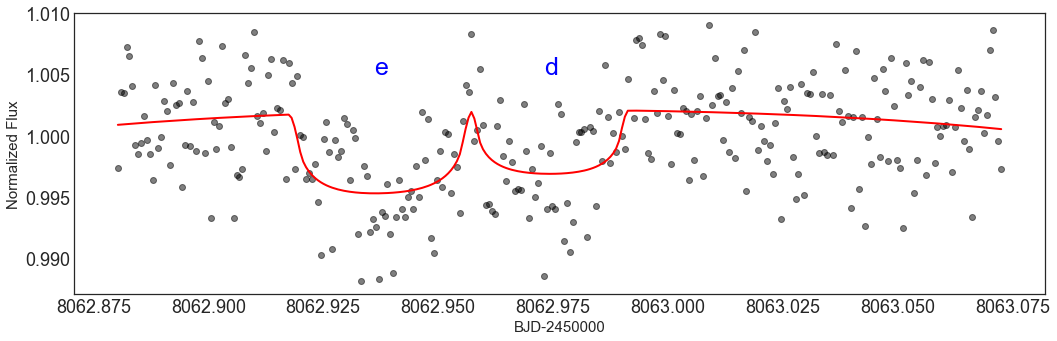

In [53]:
sys_use = sys_combination[good_number[num]]
transit_params_after = paramsmc[:4]
sys_params_after = paramsmc[4:]
full_params = paramsmc

transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
sys_model = np.dot(sys_use,sys_params_after)

transit_model_before = transit_model_q(transit_params,transit_fix, time, model=MandelAgol())
print('\nsystematics is' ,free[good_number[num]])
#compute rms
rms_after = rms(flux,sys_model*transit_model)
print('rms w/o systematics:\n{:.8f}'.format(rms_after))
        
#compute BIC
num_d=len(time)
num_p=full_params.size
chi2 = chisq(flux,sys_model*transit_model,err)
        
dof = num_d - num_p
red_chi2 = chi2 / dof
BIC = chi2 + num_p * np.log(num_d)
        
print('chisq:\n{:.8f}'.format(chi2))
print('reduced_chisq:\n{:.8f}'.format(red_chi2))
print('BIC: {:.4f}'.format(BIC))

fig = pl.figure(figsize=(15,5))
#plot corrected data
pl.plot(time, flux, 'ko', alpha=0.5)
#pl.set_title('raw data & transit+systematics models (z-band)', fontsize=18)
#plot transit+sys models
#pl.plot(time, transit_model_before*sys_model, 'b-', lw=2, label='before',alpha=0.5)
pl.plot(time, transit_model*sys_model, 'r-', lw=2)
pl.xlabel('BJD-2450000')
pl.ylabel('Normalized Flux')
pl.text(8062.936,1.005,"e",fontsize=25,color='b')
pl.text(8062.973,1.005,"d",fontsize=25,color='b')
fig.tight_layout()

BICもわずかによくなっている。　　

しかしこれを答えとする前に、本当にMCMCのチェーンは収束したのかを確認する必要がある。いくつかの収束の確認法を行う。  
まずは、各ステップごとのチェーンの動きを見てみる。(100点が10000ステップ動いているような図。)

In [54]:
ys=['k_d','Tc_d','k_e','Tc_e','w0','w1']

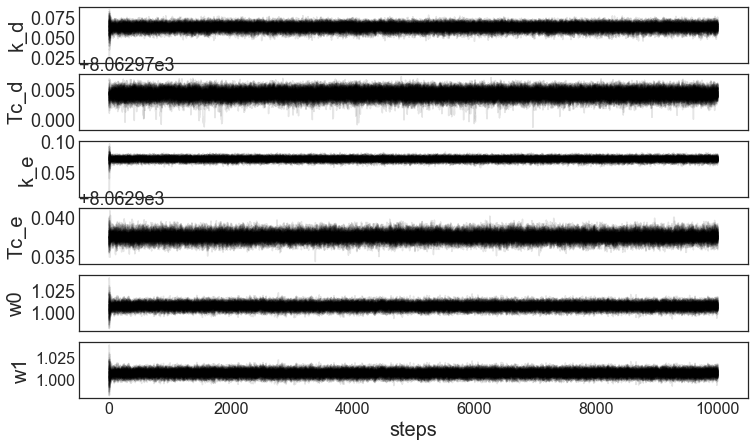

In [55]:
fig, ax = pl.subplots(dim, 1, figsize=(10*1.2,dim*1.2))


for i in range(dim-1):
    ax[i].plot(sampler.chain[:,:,i].T, color='k', alpha=0.1)
    pl.setp(ax[i].get_xticklabels(), visible=False)
    pl.setp(ax[i].get_yticklabels(), fontsize=18)
    ax[i].set_ylabel(ys[i],fontsize=20)

ax[dim-1].plot(sampler.chain[:,:,i].T, color='k', alpha=0.1)
pl.setp(ax[dim-1].get_xticklabels(), fontsize=16)
pl.setp(ax[dim-1].get_yticklabels(), fontsize=16)
ax[dim-1].set_ylabel(ys[dim-1],fontsize=20)

ax[dim-1].set_xlabel('steps',fontsize=20)

チェーンを眺めてみると、程よく広がったところから収束していっているのを確認できる(そうなるように初期値のばらつきを設定した。)  
チェーンの最初の部分はまだ収束していないので(burn-inと呼ばれる）、ここは取り除いて各パラメタの分布を見てみる。

In [56]:
samples=sampler.chain[:,2000:, :].reshape(-1,dim)

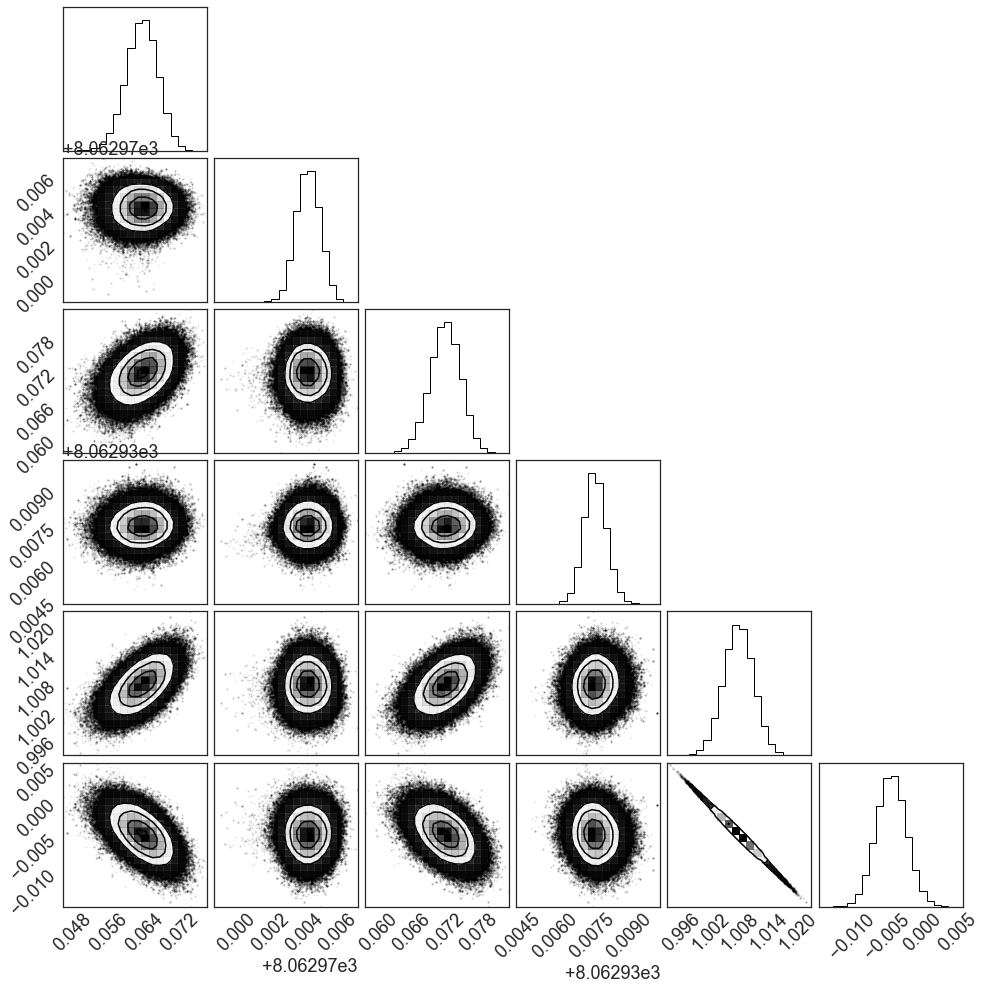

In [57]:
import corner
fig = corner.corner(samples, fontsize=10)

どの値も綺麗なガウシアン状に広がっている。  
airmassとoffsetに共分散が見られるが、線形なら問題ない。

In [58]:
choice=np.random.randint(0,500,100)

MCMCのチェーンの中からランダムに100個のセットを持ってきて図にしてみると以下のようになる。

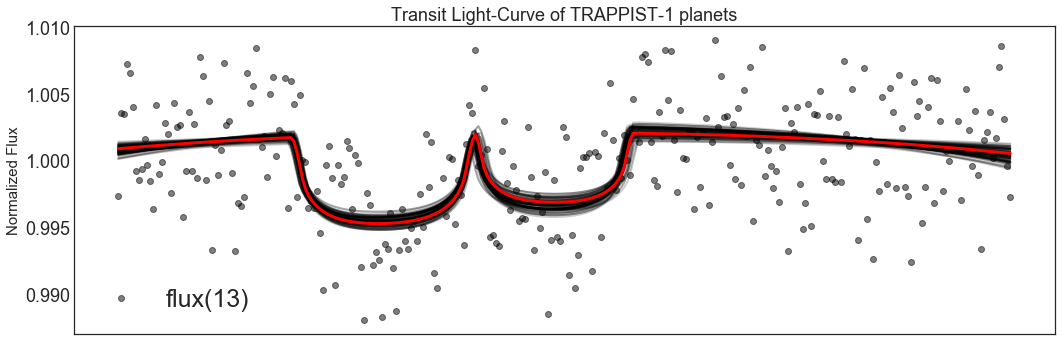

In [60]:
sys_use = sys_combination[good_number[num]]


fig = pl.figure(figsize=(15,5))

for i in range(len(choice)):
    paramsmc=samples[choice[i]]
    transit_params_after = paramsmc[:4]
    sys_params_after = paramsmc[4:]
    full_params = paramsmc

    transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
    sys_model = np.dot(sys_use,sys_params_after)

    pl.plot(time, transit_model*sys_model, 'k-',lw=2,alpha=0.2)

idx = np.argmax(sampler.flatlnprobability)
paramsmc = sampler.flatchain[idx]
transit_params_after = paramsmc[:4]
sys_params_after = paramsmc[4:]
full_params = paramsmc

transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
sys_model = np.dot(sys_use,sys_params_after)
pl.plot(time, flux, 'ko', alpha=0.5)
pl.plot(time, transit_model*sys_model, 'r-',lw=3,alpha=1)
pl.tick_params(labelbottom="off")
#pl.xlabel('BJD-2450000')
pl.ylabel('Normalized Flux')
#pl.text(8062.936,1.005,"e",fontsize=25,color='r')
#pl.text(8062.973,1.005,"d",fontsize=25,color='r')
pl.title('Transit Light-Curve of TRAPPIST-1 planets')
pl.legend(fontsize=25)
fig.tight_layout()

残差をプロットしてみて、綺麗にフィットできているか確認する。

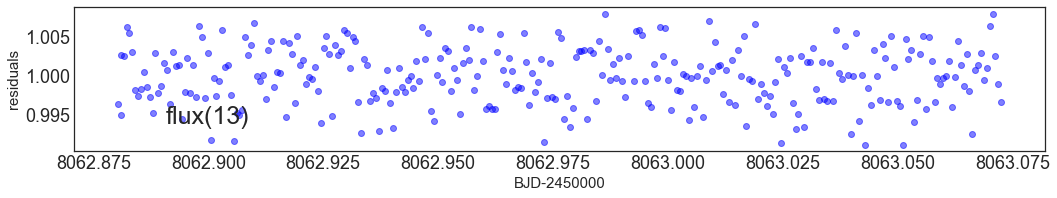

In [61]:
fig = pl.figure(figsize=(15,3))

transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
sys_model = np.dot(sys_use,sys_params_after)

resid = flux/(transit_model*sys_model)

pl.plot(time, resid, 'bo', alpha=0.5)
pl.xlabel('BJD-2450000')
pl.ylabel('residuals')
#pl.text(8062.936,1.005,"e",fontsize=25,color='r')
#pl.text(8062.973,1.005,"d",fontsize=25,color='r')
#pl.title('Transit Light-Curve of TRAPPIST-1 planets')
pl.legend(fontsize=25)
fig.tight_layout()

この時の全チェーンのパラメタの値を保存しておく。

In [63]:
df_chain= pd.DataFrame(samples)
df_chain.columns = ['k_d','Tc_d','k_e','Tc_e','w0(offset)','w1(airmass)']#change
df_chain.to_csv('df_chain_0_new.csv')#change
df_chain.head(3)

,k_d,Tc_d,k_e,Tc_e,w0(offset),w1(airmass)
0,0.061791,8062.973398,0.067608,8062.937494,1.009202,-0.005430
1,0.059651,8062.973431,0.066465,8062.937484,1.008334,-0.004831
2,0.059651,8062.973431,0.066465,8062.937484,1.008334,-0.004831


ちなみにこれを用いると各パラメタの中央値や分散がわかる。

In [64]:
df_chain.describe()

,k_d,Tc_d,k_e,Tc_e,w0(offset),w1(airmass)
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.063457,8062.974230,0.071949,8062.937608,1.007758,-0.004393
std,0.003525,0.000697,0.002751,0.000466,0.003103,0.002168
min,0.045665,8062.968624,0.057629,8062.934419,0.993047,-0.014780
25%,0.061138,8062.973748,0.070137,8062.937304,1.005672,-0.005861
50%,0.063542,8062.974229,0.071998,8062.937597,1.007772,-0.004399
75%,0.065885,8062.974712,0.073829,8062.937904,1.009858,-0.002938
max,0.078020,8062.977193,0.083403,8062.940238,1.022932,0.005790


収束性を確認するもう一つの方法。autocorrelation lengthを計算する。
tauで割った値が~10000ならば誤差の精度が1%といえる  
（詳細はhttps://dfm.io/posts/autocorr/ )

In [65]:
from acor import acor
tau, mean, sigma = acor(df_chain['Tc_d'])
result = np.array(df_chain['Tc_d'])[::int(tau)]
len(result)

11941

これで収束性も確認できた。
同様のことをnumの値を変え繰り返していく。  
Gillon et al.(2017)とWang et al.(2017)の値を用いてトランジット中心の時刻からTTVの時間を計算すると、最終的に以下の結果が得られる。

In [67]:
datadir = '.'
path    = os.path.join(datadir,'df_chain*new.csv')
file_list = glob(path)
file_list = sorted(file_list)
file_list=file_list[::]
file_list

['./df_chain_0_new.csv',
 './df_chain_1_new.csv',
 './df_chain_2_new.csv',
 './df_chain_3_new.csv',
 './df_chain_4_new.csv',
 './df_chain_5_new.csv',
 './df_chain_6_new.csv',
 './df_chain_7_new.csv',
 './df_chain_8_new.csv',
 './df_chain_9_new.csv']

In [68]:
good_free=[]
for n in range(len(good_number)):
    good_free.append(free[good_number[n]])
good_free

[['airmass'],
 ['dy'],
 ['sky'],
 ['dx'],
 ['del_time'],
 ['airmass', 'sky'],
 ['dy', 'sky'],
 ['dy', 'airmass'],
 ['airmass', 'del_time'],
 ['dx', 'airmass']]

In [71]:
Tcd_list=[]
Tcd_err_list=[]
Tce_list=[]
Tce_err_list=[]
Tcd_wang_list=[]
Tcd_wang_err_list=[]
Tce_wang_list=[]
Tce_wang_err_list=[]
TTV_d_list=[]
TTV_d_err_list=[]
TTV_e_list=[]
TTV_e_err_list=[]
TTV_gillon_d_list=[]
TTV_gillon_d_err_list=[]
TTV_gillon_e_list=[]
TTV_gillon_e_err_list=[]

for n in range(len(good_number)):
    df_chain = pd.read_csv(file_list[n], delimiter=',', parse_dates=True)
    df_chain = df_chain.drop('Unnamed: 0',axis=1)
    
    ad,bd,cd=np.percentile(df_chain['Tc_d'], [16, 50, 84], axis=0)
    del1d=bd-ad
    del2d=cd-bd
    tcd_goal=bd
    
    ae,be,ce=np.percentile(df_chain['Tc_e'], [16, 50, 84], axis=0)
    del1e=be-ae
    del2e=ce-be
    tce_goal=be
    
    Tcd_goal=ufloat(tcd_goal,max(del1d,del2d))
    Tce_goal=ufloat(tce_goal,max(del1e,del2e))
    
    Tcd_list.append(Tcd_goal.n)
    Tcd_err_list.append(Tcd_goal.s)
    Tce_list.append(Tce_goal.n)
    Tce_err_list.append(Tce_goal.s)
    
    Tcd_wang_goal=Tcd_goal+2450000-2457738.3654
    Tce_wang_goal=Tce_goal+2450000-2457738.3654
    
    Tcd_wang_list.append(Tcd_wang_goal.n)
    Tcd_wang_err_list.append(Tcd_wang_goal.s)
    Tce_wang_list.append(Tce_wang_goal.n)
    Tce_wang_err_list.append(Tce_wang_goal.s)
    
    TTV_d_wang=(Tcd_goal-tc_d)*24*60
    TTV_e_wang=(Tce_goal-tc_e)*24*60
    
    TTV_gillon_d=(Tcd_goal-tc_d_gillon)*24*60
    TTV_gillon_e=(Tce_goal-tc_e_gillon)*24*60
    
    TTV_d_list.append(TTV_d_wang.n)
    TTV_d_err_list.append(TTV_d_wang.s)
    TTV_e_list.append(TTV_e_wang.n)
    TTV_e_err_list.append(TTV_e_wang.s) 
    TTV_gillon_d_list.append(TTV_gillon_d.n)
    TTV_gillon_d_err_list.append(TTV_gillon_d.s)
    TTV_gillon_e_list.append(TTV_gillon_e.n)
    TTV_gillon_e_err_list.append(TTV_gillon_e.s) 

In [72]:
df_TTV=pd.DataFrame({'free':good_free,\
                     'Tc_d(BJD-2450000)':Tcd_list,'Tc_d_err':Tcd_err_list,\
                     'Tc_e(BJD-2450000)':Tce_list,'Tc_e_err':Tce_err_list,\
                     'TTV_d_wang':TTV_d_list,'TTV_d_err_wang':TTV_d_err_list,\
                     'TTV_e_wang':TTV_e_list,'TTV_e_err_wang':TTV_e_err_list,\
                     'TTV_d_gillon':TTV_gillon_d_list,'TTV_d_err_gillon':TTV_gillon_d_err_list,\
                     'TTV_e_gillon':TTV_gillon_e_list,'TTV_e_err_gillon':TTV_gillon_e_err_list})
df_TTV=df_TTV[['free','Tc_d(BJD-2450000)','Tc_d_err',\
              'Tc_e(BJD-2450000)','Tc_e_err',\
              'TTV_d_wang','TTV_d_err_wang','TTV_e_wang','TTV_e_err_wang',\
              'TTV_d_gillon','TTV_d_err_gillon','TTV_e_gillon','TTV_e_err_gillon']]
df_TTV

,free,Tc_d(BJD-2450000),Tc_d_err,Tc_e(BJD-2450000),Tc_e_err,TTV_d_wang,TTV_d_err_wang,TTV_e_wang,TTV_e_err_wang,TTV_d_gillon,TTV_d_err_gillon,TTV_e_gillon,TTV_e_err_gillon
0,[airmass],8062.974224,0.000721,8062.937585,0.000471,-1.376734,1.038319,-15.716944,0.677929,29.381666,8.875207,-22.456144,1.360867
1,[dy],8062.974216,0.000758,8062.937537,0.000464,-1.387837,1.091112,-15.787056,0.667559,29.370563,8.881538,-22.526256,1.355731
2,[sky],8062.974265,0.000781,8062.937544,0.000473,-1.317834,1.124767,-15.776404,0.680614,29.440566,8.885736,-22.515604,1.362207
3,[dx],8062.974169,0.000791,8062.937476,0.000456,-1.456249,1.139077,-15.873887,0.656383,29.302151,8.887558,-22.613087,1.350263
4,[del_time],8062.974189,0.000782,8062.937475,0.000456,-1.427449,1.126677,-15.876593,0.657355,29.330951,8.885978,-22.615793,1.350736
5,"[airmass, sky]",8062.974261,0.000682,8062.937663,0.000468,-1.323777,0.982666,-15.605660,0.673859,29.434623,8.868869,-22.344860,1.358845
6,"[dy, sky]",8062.974234,0.000751,8062.937556,0.000468,-1.362068,1.080842,-15.759876,0.673237,29.396332,8.880283,-22.499076,1.358536
7,"[dy, airmass]",8062.974204,0.000707,8062.937600,0.000463,-1.404874,1.018072,-15.696694,0.666568,29.353526,8.872861,-22.435894,1.355244
8,"[airmass, del_time]",8062.974170,0.000722,8062.937559,0.000454,-1.454427,1.039769,-15.755319,0.654022,29.303973,8.875377,-22.494519,1.349117
9,"[dx, airmass]",8062.974192,0.000720,8062.937566,0.000455,-1.423232,1.037414,-15.744464,0.655016,29.335168,8.875102,-22.483664,1.349599


どのパラメタセットを使っても、得られたTcの値は1$\sigma$の範囲で一致しているとわかる。